Number of particles in file ../track_files/surface_source.mcpl: 3514158
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Index: 1
Sampling 100000 samples to get 100000 samples in total


KeyboardInterrupt: 

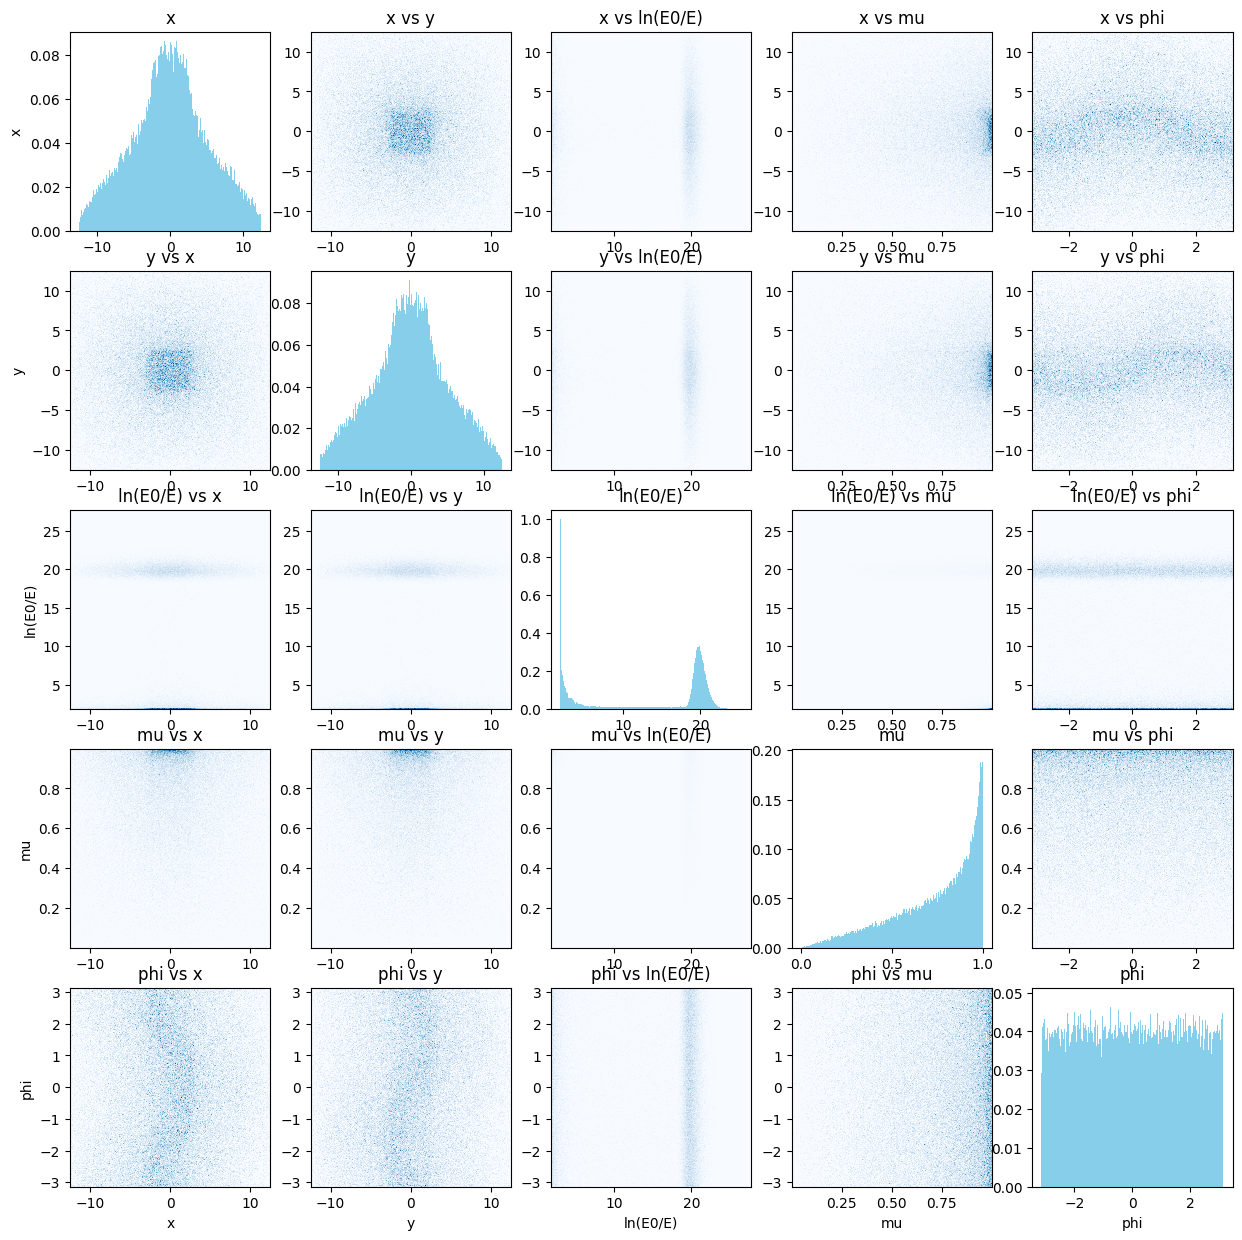

In [3]:
# %load_ext autoreload
# %autoreload 2
import sys

sys.path.append("../")
from functions import *

# %matplotlib widget

# Data to test
columns_order = [
    ["x", "y", "ln(E0/E)", "mu", "phi"],
    # ["ln(E0/E)", "x", "y", "mu", "phi"],
]
micro_bins = [
    # [200] * len(columns_order[0]),
    [300] * len(columns_order[0]),
]
macro_bins = [[15, 10, 8, 6, 5], 
            #   [10, 10, 10, 10, 10], 
            #   [5, 6, 8, 10, 15],
              ]
N_max = [1e5]
type = ["equal_area"]

columns_order, micro_bins, macro_bins, N, type = barrido_combinations(
    columns_order, micro_bins, macro_bins, N_max, type, min_batch_size=1e5
)
N_max = [n.sum() for n in N]

save_information(type, N_max, columns_order, micro_bins, macro_bins)

SurfaceSourceFile = kds.SurfaceSourceFile(
    "../track_files/surface_source.mcpl", domain={"w": [0, 2]}
)
df = SurfaceSourceFile.get_pandas_dataframe()
df = df[["x", "y", "ln(E0/E)", "mu", "phi", "wgt"]]
del SurfaceSourceFile

# Run test
barrido(
    columns_order,
    micro_bins,
    macro_bins,
    N,
    type,
    df,
    bins_for_comparation=300,
    value_to_replace_0=None,
)

get_min_max(len(columns_order), len(columns_order[0]))

comparacion_barrido(len(columns_order))

In [6]:
import numpy as np

a = np.array([[[1,2,3],[4,5,6]],[[7,0,9],[10,11,12]]])
b = np.array([[[18,7,5],[43,5,3]],[[0,0,9],[1,0,1]]])

print(a[a!=0])
print(b[a!=0])
print(a[a<5].size)

for i,a in enumerate(a):
    print(a)
    print(a.size)
    print(i)

[ 1  2  3  4  5  6  7  9 10 11 12]
[18  7  5 43  5  3  0  9  1  0  1]
5
[[1 2 3]
 [4 5 6]]
6
0
[[ 7  0  9]
 [10 11 12]]
6
1


In [1]:
a = -5
b = abs(a)

print(b)

5


In [34]:
import os
from PIL import Image, ImageDraw, ImageFont
import numpy as np

def combine_images(num_folders: int, image_name: str = "1000000.png"):
    # Assuming all

    # Path to the main directory containing folders 1, 2, ..., 12
    main_dir = "./"  # Replace with the correct path if running from a different folder
    output_path = os.path.join(main_dir, "combined.png")  # Path for the output image

    # Parameters for the grid of images
    images_per_folder = 3
    images_names = [image_name, "original.png", "results.png"]

    # Assuming all images are the same size, get the dimensions of a sample image
    sample_image = Image.open(os.path.join(main_dir, "1", images_names[0]))
    img_width, img_height = sample_image.size
    sample_image.close()

    # Maximum pixels for the output image
    max_pixels = 3e7

    # Calculate reduction factor to keep final image size within max_pixels
    reducing_factor = np.sqrt(
        max_pixels / (img_width * img_height * images_per_folder * num_folders)
    )

    # New dimensions for each individual resized image
    new_img_width = int(img_width * reducing_factor)
    new_img_height = int(img_height * reducing_factor)

    # Define separator thickness and additional padding for labels
    row_separator_thickness = 5  # Thicker line between rows
    column_separator_thickness = 2  # Thinner line between columns
    label_padding = int(new_img_height * 0.1)  # Additional padding for label text

    # Dimensions of the final combined image, including padding for labels
    combined_width = new_img_width * images_per_folder + (images_per_folder - 1) * column_separator_thickness
    combined_height = (new_img_height + label_padding) * num_folders + (num_folders - 1) * row_separator_thickness

    # Create a blank image with extra space for separators and labels
    combined_img = Image.new("RGB", (combined_width, combined_height), "white")

    # Load a small font
    font_size = int(new_img_height * 0.1)  # Relative font size based on image height
    try:

        font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", font_size)
    except IOError:
        print('prrr')
        font = ImageFont.load_default()  # Use default font if custom font fails

    # Draw object to add lines and text
    draw = ImageDraw.Draw(combined_img)

    # Loop through each folder and each image within it
    for i in range(1, num_folders + 1):
        folder_path = os.path.join(main_dir, str(i))

        # Calculate y position with row separator space
        y_offset = (i - 1) * (new_img_height + label_padding + row_separator_thickness) - int(new_img_height * 0.1)

        # Add row label at the top of each row
        label_text = f"INDEX = {i}"
        text_width, text_height = draw.textsize(label_text, font=font)
        text_x = (combined_width - text_width) // 2
        draw.text((text_x, y_offset + int(new_img_height * 0.1)), label_text, fill="black", font=font)

        for j in range(1, images_per_folder + 1):
            img_path = os.path.join(folder_path, images_names[j - 1])
            img = Image.open(img_path)

            # Resize the image according to the reducing factor
            img_resized = img.resize((new_img_width, new_img_height))

            # Calculate x position with column separator space
            x_offset = (j - 1) * (new_img_width + column_separator_thickness)

            # Paste the resized image into the combined image
            combined_img.paste(img_resized, (x_offset, y_offset + text_height + label_padding))
            img.close()

    # Draw separators
    for i in range(1, num_folders):
        # Horizontal (row) separators
        y_position = i * (new_img_height + label_padding + row_separator_thickness) - row_separator_thickness // 2
        draw.line([(0, y_position), (combined_width, y_position)], fill="black", width=row_separator_thickness)

    for j in range(1, images_per_folder):
        # Vertical (column) separators
        x_position = j * (new_img_width + column_separator_thickness) - column_separator_thickness // 2
        draw.line([(x_position, 0), (x_position, combined_height)], fill="black", width=column_separator_thickness)

    # Save the final combined image
    combined_img.save(output_path)

    # Free up resources
    combined_img.close()


/tmp/ipykernel_21815/2362700055.py:64: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(label_text, font=font)
/tmp/ipykernel_21815/2362700055.py:64: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(label_text, font=font)
/tmp/ipykernel_21815/2362700055.py:64: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(label_text, font=font)
/tmp/ipykernel_21815/2362700055.py:64: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(label_text, font=font)
/tmp/ipykernel_21815/2362700055.py:64: DeprecationWarning: textsize is deprecate

Combined image saved as ./combined_with_grid_fixed.png
